In [ ]:
from torch.utils.tensorboard import SummaryWriter


%load_ext tensorboard
tb = SummaryWriter('/content/drive/My Drive/runs')
%tensorboard --logdir '/content/drive/My Drive/runs'

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os, cv2
import xml.etree.ElementTree as ET
import copy

import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
from skimage.transform import resize

import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import tensorflow as tf

In [ ]:


LABELS = ['aeroplane',  'bicycle', 'bird', 'boat', 'bottle', 
          'bus', 'car', 'cat', 'chair', 'cow','diningtable','dog', 'horse', 'motorbike', 'person',
          'pottedplant','sheep', 'sofa', 'train', 'tvmonitor']

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    count = 0    
    for ann in os.listdir(ann_dir):

        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]                
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        count += 1
        if count % 2000 == 0:
            break
        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs



def normalize(image):
    return image / 255.


class ImageReader(object):
    def __init__(self,IMAGE_H,IMAGE_W, norm=None):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True):     
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance):
        image_name = train_instance['filename']
        image = cv2.imread(os.path.join(IMAGE_PATH, image_name))
        h, w, c = image.shape
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        # if "object" in train_instance.keys():
            
        #     all_objs = copy.deepcopy(train_instance['object'])     

        #     for obj in all_objs:
        #         for attr in ['xmin', 'xmax']:
        #             obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
        #             obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

        #         for attr in ['ymin', 'ymax']:
        #             obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
        #             obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        return image


# class BestAnchorBoxFinder(object):
#     def __init__(self, ANCHORS):
#         self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
#                         for i in range(int(len(ANCHORS)//2))]
       
#     def _interval_overlap(self,interval_a, interval_b):
#         x1, x2 = interval_a
#         x3, x4 = interval_b
#         if x3 < x1:
#             if x4 < x1:
#                 return 0
#             else:
#                 return min(x2,x4) - x1
#         else:
#             if x2 < x3:
#                  return 0
#             else:
#                 return min(x2,x4) - x3  

#     def bbox_iou(self,box1, box2):
#         intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
#         intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

#         intersect = intersect_w * intersect_h

#         w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
#         w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

#         union = w1*h1 + w2*h2 - intersect

#         return float(intersect) / union
    
#     def find(self,center_w, center_h):
#         best_anchor = -1
#         max_iou     = -1
#         shifted_box = BoundBox(0, 0,center_w, center_h)
#         for i in range(len(self.anchors)):
#             anchor = self.anchors[i]
#             iou    = self.bbox_iou(shifted_box, anchor)
#             if max_iou < iou:
#                 best_anchor = i
#                 max_iou     = iou
#         return(best_anchor,max_iou)    
    
    
# class BoundBox:
#     def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
#         self.xmin, self.ymin = xmin, ymin
#         self.xmax, self.ymax = xmax, ymax
#         self.confidence = confidence
#         self.set_class(classes)
        
#     def set_class(self,classes):
#         self.classes = classes
#         self.label = np.argmax(self.classes) 
        
#     def get_label(self):  
#         return(self.label)
    
#     def get_score(self):
#         return(self.classes[self.label])



# def rescale_centerxy(obj,config):
#     center_x = .5*(obj['xmin'] + obj['xmax'])
#     center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
#     center_y = .5*(obj['ymin'] + obj['ymax'])
#     center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
#     return(center_x,center_y)

# def rescale_centerwh(obj,config):
#     center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
#     center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
#     return(center_w,center_h)
IMAGE_PATH = '/content/drive/My Drive/test1/dataset/JPEGImages'

class VOCPascal(Dataset):
    def __init__(self, csv_file, config, norm=None, train=True):
        self.main_file = csv_file
        self.config = config
        self.train = train
        self.config["CLASS"] = len(self.config['LABELS'])
        self.norm = norm


    def encode_core(self,image, reorder_rgb=True):     
        image = cv2.resize(image, (320, 320))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
            

    def __len__(self):
        return self.main_file.shape[0]


    def __getitem__(self, idx):
        image_name = self.main_file.iloc[idx]['filename']
        image = cv2.imread(os.path.join(IMAGE_PATH, image_name))
        h, w = self.main_file.iloc[idx]['height'], self.main_file.iloc[idx]['width']
        if self.train:
            image = self.encode_core(image, reorder_rgb=True)
            image = torch.from_numpy(np.array(image)).float()
            image = image.permute(2, 0, 1)


            boxes = torch.zeros(60, 4, dtype=torch.float)
            gt_classes = torch.zeros(60, dtype=torch.float)      
            data = self.main_file.iloc[idx, :]
            for count in range(int(data['obj'])):
                boxes[count, :] = torch.tensor([float(data[f'bbox_{count}_xmin']), float(data[f'bbox_{count}_ymin']), float(data[f'bbox_{count}_xmax']), float(data[f'bbox_{count}_ymax'])])
                gt_classes[count] = torch.tensor([self.config['LABELS'].index(data[f'bbox_{count}_name'])])
            
            boxes[:,0::2] = torch.clamp(boxes[:, 0::2] / w, 0.001, 0.999)
            boxes[:,1::2] = torch.clamp(boxes[:, 1::2] / h, 0.001, 0.999)
            num_obj = torch.Tensor([int(data['obj'])]).long()
            return image, boxes, gt_classes, num_obj

        else:
            image_name = self.main_file.iloc[idx]['filename']
            image_info = torch.FloatTensor([w, h])
            image = cv2.resize(image, (320, 320))
            image = self.norm(image)
            image = torch.from_numpy(np.array(image)).float()
            image = image.permute(2, 0, 1)
            return image, image_info, image_name

In [ ]:
class WeightLoader(object):
    def __init__(self):
        super(WeightLoader, self).__init__()
        self.start = 0
        self.buf = None

    def load_conv_bn(self, conv_model, bn_model):
        num_w = conv_model.weight.numel()
        num_b = bn_model.bias.numel()
        bn_model.bias.data.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_b]), bn_model.bias.size()))
        self.start = self.start + num_b
        bn_model.weight.data.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_b]), bn_model.bias.size()))
        self.start = self.start + num_b
        bn_model.running_mean.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_b]), bn_model.bias.size()))
        self.start = self.start + num_b
        bn_model.running_var.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_b]), bn_model.bias.size()))
        self.start = self.start + num_b
        conv_model.weight.data.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_w]), conv_model.weight.size()))
        self.start = self.start + num_w

    def load_conv(self, conv_model):
        num_w = conv_model.weight.numel()
        num_b = conv_model.bias.numel()
        conv_model.bias.data.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_b]), conv_model.bias.size()))
        self.start = self.start + num_b
        conv_model.weight.data.copy_(
            torch.reshape(torch.from_numpy(self.buf[self.start:self.start + num_w]), conv_model.weight.size()))
        self.start = self.start + num_w

    def dfs(self, m):
        children = list(m.children())
        for i, c in enumerate(children):
            if isinstance(c, torch.nn.Sequential):
                self.dfs(c)
            elif isinstance(c, torch.nn.Conv2d):
                if c.bias is not None:
                    self.load_conv(c)
                else:
                    self.load_conv_bn(c, children[i + 1])

    def load(self, model, weights_file):
        self.start = 0
        fp = open(weights_file, 'rb')
        header = np.fromfile(fp, count=4, dtype=np.int32)
        self.buf = np.fromfile(fp, dtype=np.float32)
        fp.close()
        size = self.buf.size
        self.dfs(model)

        assert size == self.start



class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        N = x.data.size(0)
        C = x.data.size(1)
        H = x.data.size(2)
        W = x.data.size(3)
        x = F.avg_pool2d(x, (H, W))
        x = x.view(N, C)
        return x

def conv_bn_leaky(in_channels, out_channels, kernel_size, return_module=False):
    padding = int((kernel_size - 1) / 2)
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                        stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1, inplace=True)]
    if return_module:
        return nn.Sequential(*layers)
    else:
        return layers

class Darknet19(nn.Module):
    def _make_layers(self, layer_cfg):
        layers = []
        kernel_size = 3
        for v in layer_cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += conv_bn_leaky(self.in_channels, v, kernel_size)
                kernel_size = 1 if kernel_size == 3 else 3
                self.in_channels = v
        return nn.Sequential(*layers)
    
    cfg = {
        'layer0': [32],
        'layer1': ['M', 64],
        'layer2': ['M', 128, 64, 128],
        'layer3': ['M', 256, 128, 256],
        'layer4': ['M', 512, 256, 512, 256, 512],
        'layer5': ['M', 1024, 512, 1024, 512, 1024]
    }

    def __init__(self, num_classes=1000):
        super(Darknet19, self).__init__()
        self.in_channels = 3

        self.layer0 = self._make_layers(self.cfg['layer0'])
        self.layer1 = self._make_layers(self.cfg['layer1'])
        self.layer2 = self._make_layers(self.cfg['layer2'])
        self.layer3 = self._make_layers(self.cfg['layer3'])
        self.layer4 = self._make_layers(self.cfg['layer4'])
        self.layer5 = self._make_layers(self.cfg['layer5'])

        self.conv = nn.Conv2d(self.in_channels, num_classes, kernel_size=1, stride=1)
        self.avgpool = GlobalAvgPool2d()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.conv(x)
        x = self.avgpool(x)
        x = self.softmax(x)

        return x

    def load_weights(self, weights_file):
        weights_loader = WeightLoader()
        weights_loader.load(self, weights_file)

class ReorgLayer(nn.Module):
    def __init__(self, stride=2):
        super(ReorgLayer, self).__init__()
        self.stride = stride

    def forward(self, x):
        B, C, H, W = x.data.size()
        ws = self.stride
        hs = self.stride
        x = x.view(B, C, int(H / hs), hs, int(W / ws), ws).transpose(3, 4).contiguous()
        x = x.view(B, C, int(H / hs * W / ws), hs * ws).transpose(2, 3).contiguous()
        x = x.view(B, C, hs * ws, int(H / hs), int(W / ws)).transpose(1, 2).contiguous()
        x = x.view(B, hs * ws * C, int(H / hs), int(W / ws))
        return x


class Yolov2(nn.Module):

    num_classes = 20
    num_anchors = 5

    def __init__(self, classes=None, weights_file=False):
        super(Yolov2, self).__init__()
        if classes:
            self.num_classes = len(classes)

        darknet19 = Darknet19()

        if weights_file:
            print('load pretrained weight from {}'.format(weights_file))
            darknet19.load_weights(weights_file)
            print('pretrained weight loaded!')

        self.conv1 = nn.Sequential(darknet19.layer0, darknet19.layer1,
                                   darknet19.layer2, darknet19.layer3, darknet19.layer4)

        self.conv2 = darknet19.layer5

        self.conv3 = nn.Sequential(conv_bn_leaky(1024, 1024, kernel_size=3, return_module=True),
                                   conv_bn_leaky(1024, 1024, kernel_size=3, return_module=True))

        self.downsampler = conv_bn_leaky(512, 64, kernel_size=1, return_module=True)

        self.conv4 = nn.Sequential(conv_bn_leaky(1280, 1024, kernel_size=3, return_module=True),
                                   nn.Conv2d(1024, (5 + self.num_classes) * self.num_anchors, kernel_size=1))

        self.reorg = ReorgLayer()

    def forward(self, x):
        x = self.conv1(x)
        shortcut = self.reorg(self.downsampler(x))
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.cat([shortcut, x], dim=1)
        out = self.conv4(x)


        bsize, _, h, w = out.size()
        out  = out.permute(0, 2, 3, 1).contiguous().view(bsize, h * w * self.num_anchors, 5 + self.num_classes)

        
       

        xy_pred = torch.sigmoid(out[:, :, 0:2])
        conf_pred = torch.sigmoid(out[:, :, 4:5])
        hw_pred = torch.exp(out[:, :, 2:4])
        class_pred = F.softmax(out[:, :, 5:], dim=-1)
        delta_pred = torch.cat([xy_pred, hw_pred], dim=-1)

        for i in range(bsize):
            output = [delta_pred[i], conf_pred[i], class_pred[i]]
            im_info = {'width': w, 'height': h}
            detections = yolo_eval(output, im_info, conf_threshold=0.2,
                                          nms_threshold=0.4)
        
        det_classes = detections[:,-1]
        return det_classes
      

In [ ]:
def box_ious(box1, box2):
    N = box1.size(0)
    K = box2.size(0)

    xi1 = torch.max(box1[:, 0].view(N, 1), box2[:, 0].view(1, K))
    yi1 = torch.max(box1[:, 1].view(N, 1), box2[:, 1].view(1, K))
    xi2 = torch.min(box1[:, 2].view(N, 1), box2[:, 2].view(1, K))
    yi2 = torch.min(box1[:, 3].view(N, 1), box2[:, 3].view(1, K))

    iw = torch.max(xi2 - xi1, torch.tensor([0.], dtype=torch.float))
    ih = torch.max(yi2 - yi1, torch.tensor([0.], dtype=torch.float))

    inter = iw * ih

    box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    box1_area = box1_area.view(N, 1)
    box2_area = box2_area.view(1, K)

    union_area = box1_area + box2_area - inter

    ious = inter / union_area

    return ious


def xxyy2xywh(box):
    c_x = (box[:, 2] + box[:, 0]) / 2
    c_y = (box[:, 3] + box[:, 1]) / 2
    w = box[:, 2] - box[:, 0]
    h = box[:, 3] - box[:, 1]

    c_x = c_x.view(-1, 1)
    c_y = c_y.view(-1, 1)
    w = w.view(-1, 1)
    h = h.view(-1, 1)

    xywh_box = torch.cat([c_x, c_y, w, h], dim=1)
    return xywh_box


def xywh2xxyy(box):
    x1 = box[:, 0] - (box[:, 2]) / 2
    y1 = box[:, 1] - (box[:, 3]) / 2
    x2 = box[:, 0] + (box[:, 2]) / 2
    y2 = box[:, 1] + (box[:, 3]) / 2

    x1 = x1.view(-1, 1)
    y1 = y1.view(-1, 1)
    x2 = x2.view(-1, 1)
    y2 = y2.view(-1, 1)

    xxyy_box = torch.cat([x1, y1, x2, y2], dim=1)
    return xxyy_box


def box_transform(box1, box2):
    t_x = box2[:, 0] - box1[:, 0]
    t_y = box2[:, 1] - box1[:, 1]
    t_w = box2[:, 2] / box1[:, 2]
    t_h = box2[:, 3] / box1[:, 3]

    t_x = t_x.view(-1, 1)
    t_y = t_y.view(-1, 1)
    t_w = t_w.view(-1, 1)
    t_h = t_h.view(-1, 1)

    # σ(t_x), σ(t_y), exp(t_w), exp(t_h)
    deltas = torch.cat([t_x, t_y, t_w, t_h], dim=1)
    return deltas


def box_transform_inv(box, deltas):
    c_x = box[:, 0] + deltas[:, 0]
    c_y = box[:, 1] + deltas[:, 1]
    w = box[:, 2] * deltas[:, 2]
    h = box[:, 3] * deltas[:, 3]

    c_x = c_x.view(-1, 1)
    c_y = c_y.view(-1, 1)
    w = w.view(-1, 1)
    h = h.view(-1, 1)

    pred_box = torch.cat([c_x, c_y, w, h], dim=-1)
    return pred_box


def generate_all_anchors(anchors, H, W):
    A = anchors.size(0)

    K = H * W

    shift_x, shift_y = torch.meshgrid([torch.arange(0, W), torch.arange(0, H)])

    shift_x = shift_x.t().contiguous()
    shift_y = shift_y.t().contiguous()

    c_x = shift_x.float()
    c_y = shift_y.float()

    centers = torch.cat([c_x.view(-1, 1), c_y.view(-1, 1)], dim=-1) 
    all_anchors = torch.cat([centers.view(K, 1, 2).expand(K, A, 2),
                             anchors.view(1, A, 2).expand(K, A, 2)], dim=-1)

    all_anchors = all_anchors.view(-1, 4)

    return all_anchors

In [ ]:
def build_target(output, gt_data, H, W):
    delta_pred_batch = output[0]
    conf_pred_batch = output[1]
    class_score_batch = output[2]

    gt_boxes_batch = gt_data[0]
    gt_classes_batch = gt_data[1]
    num_boxes_batch = gt_data[2]

    bsize = delta_pred_batch.size(0)

    num_anchors = 5 

    iou_target = delta_pred_batch.new_zeros((bsize, H * W, num_anchors, 1))
    iou_mask = delta_pred_batch.new_ones((bsize, H * W, num_anchors, 1)) * 1

    box_target = delta_pred_batch.new_zeros((bsize, H * W, num_anchors, 4))
    box_mask = delta_pred_batch.new_zeros((bsize, H * W, num_anchors, 1))

    class_target = conf_pred_batch.new_zeros((bsize, H * W, num_anchors, 1))
    class_mask = conf_pred_batch.new_zeros((bsize, H * W, num_anchors, 1))

    anchors = torch.FloatTensor([[1.3221, 1.73145], [3.19275, 4.00944], [5.05587, 8.09892], [9.47112, 4.84053], [11.2364, 10.0071]])

    all_grid_xywh = generate_all_anchors(anchors, H, W).float().cuda()
    all_anchors_xywh = all_grid_xywh.clone()
    all_anchors_xywh[:, 0:2] = all_anchors_xywh[:, 0:2].clone() + 0.5
    all_anchors_xxyy = xywh2xxyy(all_anchors_xywh.clone())

    for b in range(bsize):
        num_obj = num_boxes_batch[b].item()
        delta_pred = delta_pred_batch[b]
        gt_boxes = gt_boxes_batch[b][:num_obj, :]
        gt_classes = gt_classes_batch[b][:num_obj]

        gt_boxes[:, 0::2] = gt_boxes[:, 0::2].clone() * W
        gt_boxes[:, 1::2] = gt_boxes[:, 1::2].clone() * H

        all_anchors_xywh = all_anchors_xywh.view(-1, 4)
        box_pred = box_transform_inv(all_grid_xywh.clone(), delta_pred.clone())
        box_pred = xywh2xxyy(box_pred.clone())


        ious = box_ious(box_pred.clone(), gt_boxes.clone()) 
        ious = ious.view(-1, num_anchors, num_obj)
        max_iou, _ = torch.max(ious, dim=-1, keepdim=True)

        iou_thresh_filter = max_iou.view(-1) > 0.6
        n_pos = torch.nonzero(iou_thresh_filter).numel()

        if n_pos > 0:
            iou_mask[b][max_iou >= 0.6] = 0

        overlaps = box_ious(all_anchors_xxyy.clone(), gt_boxes.clone()).view(-1, num_anchors, num_obj)
        gt_boxes_xywh = xxyy2xywh(gt_boxes.clone())

        for t in range(gt_boxes.size(0)):

            gt_box_xywh = gt_boxes_xywh[t]
            gt_class = gt_classes[t]
            cell_idx_x, cell_idx_y = torch.floor(gt_box_xywh[:2].clone())
            cell_idx = cell_idx_y * W + cell_idx_x
            cell_idx = cell_idx.long()

            overlaps_in_cell = overlaps[cell_idx, :, t].clone()
            argmax_anchor_idx = torch.argmax(overlaps_in_cell)

            assigned_grid = all_grid_xywh.view(-1, num_anchors, 4)[cell_idx, argmax_anchor_idx, :].unsqueeze(0)
            gt_box = gt_box_xywh.unsqueeze(0)
            target_t = box_transform(assigned_grid, gt_box)
            box_target[b, cell_idx, argmax_anchor_idx, :] = target_t.unsqueeze(0)
            box_mask[b, cell_idx, argmax_anchor_idx, :] = 1

            class_target[b, cell_idx, argmax_anchor_idx, :] = gt_class
            class_mask[b, cell_idx, argmax_anchor_idx, :] = 1

            iou_target[b, cell_idx, argmax_anchor_idx, :] = max_iou[cell_idx, argmax_anchor_idx, :]
            iou_mask[b, cell_idx, argmax_anchor_idx, :] = 5

    return iou_target.view(bsize, -1, 1), \
           iou_mask.view(bsize, -1, 1), \
           box_target.view(bsize, -1, 4),\
           box_mask.view(bsize, -1, 1), \
           class_target.view(bsize, -1, 1).long(), \
           class_mask.view(bsize, -1, 1)


def yolo_loss(output, target):
    delta_pred_batch = output[0]
    conf_pred_batch = output[1]
    class_score_batch = output[2]

    iou_target = target[0]
    iou_mask = target[1]
    box_target = target[2]
    box_mask = target[3]
    class_target = target[4]
    class_mask = target[5]

    b, _, num_classes = class_score_batch.size()
    class_score_batch = class_score_batch.view(-1, num_classes)
    class_target = class_target.view(-1)
    class_mask = class_mask.view(-1)

    # ignore the gradient of noobject's target
    class_keep = class_mask.nonzero().squeeze(1)
    class_score_batch_keep = class_score_batch[class_keep, :]
    class_target_keep = class_target[class_keep]

    box_loss = 1 / b * 1 * F.mse_loss(delta_pred_batch * box_mask, box_target * box_mask, reduction='sum') / 2.0
    iou_loss = 1 / b * F.mse_loss(conf_pred_batch * iou_mask, iou_target * iou_mask, reduction='sum') / 2.0
    class_loss = 1 / b * 1 * F.cross_entropy(class_score_batch_keep, class_target_keep, reduction='sum')

    return box_loss, iou_loss, class_loss

In [ ]:
def loss_func(output, gt_boxes, gt_classes, num_boxes):
    xy_pred = torch.sigmoid(output[:, :, 0:2])
    conf_pred = torch.sigmoid(output[:, :, 4:5])
    hw_pred = torch.exp(output[:, :, 2:4])
    class_score = output[:, :, 5:]
    delta_pred = torch.cat([xy_pred, hw_pred], dim=-1)

    output_data = (delta_pred, conf_pred, class_score)
    gt_data = (gt_boxes, gt_classes, num_boxes)
    target_data = build_target(output_data, gt_data, 10, 10)

    box_loss, iou_loss, class_loss = yolo_loss(output_data, target_data)
    return box_loss, iou_loss, class_loss

In [ ]:
# def adjust_learning_rate(optimizer, lr):
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

# decay_lrs = {
#     60: 0.00001,
#     90: 0.000001
# }
data = pd.read_csv('/content/drive/My Drive/annotations.csv')
types = {}
for i in range(40, 281, 5):
  types[data.columns[i]] = 'str' 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
@torch.jit.script
def slice_helper(array, slices):
    return array[slices, :]


def yolo_filter_boxes(boxes_pred, conf_pred, classes_pred, confidence_threshold=0.6):
    cls_max_conf, cls_max_id = torch.max(classes_pred, dim=-1, keepdim=True)
    cls_conf = conf_pred * cls_max_conf

    pos_inds = (cls_conf > confidence_threshold).view(-1)

    filtered_boxes = slice_helper(boxes_pred, pos_inds)

    filtered_conf = slice_helper(conf_pred, pos_inds)

    filtered_cls_max_conf = slice_helper(cls_max_conf, pos_inds)

    filtered_cls_max_id = slice_helper(cls_max_id, pos_inds)

    return filtered_boxes, filtered_conf, filtered_cls_max_conf, filtered_cls_max_id.float()


def yolo_nms(boxes, scores, threshold):
    score_sort_index = torch.sort(scores, dim=0, descending=True)[1]

    keep = []

    while score_sort_index.numel() > 0:

        i = score_sort_index[0]
        keep.append(i)

        if score_sort_index.numel() == 1:
            break

        cur_box = boxes[score_sort_index[0], :].view(-1, 4)
        res_box = boxes[score_sort_index[1:], :].view(-1, 4)

        ious = box_ious(cur_box, res_box).view(-1)

        inds = torch.nonzero(ious < threshold).squeeze()

        score_sort_index = score_sort_index[inds + 1].view(-1)

    return torch.LongTensor(keep)


def generate_prediction_boxes(deltas_pred):
    H = 320 // 32
    W = 320 // 32
    anchors = torch.FloatTensor([[1.3221, 1.73145], [3.19275, 4.00944], [5.05587, 8.09892], [9.47112, 4.84053], [11.2364, 10.0071]])
    all_anchors_xywh = generate_all_anchors(anchors, H, W)

    all_anchors_xywh = deltas_pred.new(*all_anchors_xywh.size()).copy_(all_anchors_xywh)

    boxes_pred = box_transform_inv(all_anchors_xywh, deltas_pred)

    return boxes_pred


def scale_boxes(boxes, im_info):
    h = im_info['height']
    w = im_info['width']

    input_h, input_w = 320, 320
    scale_h, scale_w = input_h / h, input_w / w

    boxes *= 32

    boxes[:, 0::2] /= scale_w
    boxes[:, 1::2] /= scale_h

    boxes = xywh2xxyy(boxes)

    boxes[:, 0::2].clamp_(0, w-1)
    boxes[:, 1::2].clamp_(0, h-1)

    return boxes


def yolo_eval(yolo_output, im_info, conf_threshold=0.6, nms_threshold=0.4):
    deltas = yolo_output[0].cpu()
    conf = yolo_output[1].cpu()
    classes = yolo_output[2].cpu()

    num_classes = 20
    
    boxes = generate_prediction_boxes(deltas)
    

    boxes, conf, cls_max_conf, cls_max_id = yolo_filter_boxes(boxes, conf, classes, conf_threshold)


    if boxes.size(0) == 0:
        return []

    boxes = scale_boxes(boxes, im_info)

    detections = []

    cls_max_id = cls_max_id.view(-1)

    for cls in range(num_classes):
        cls_mask = cls_max_id == cls
        inds = torch.nonzero(cls_mask).squeeze()

        if inds.numel() == 0:
            continue

        boxes_pred_class = boxes[inds, :].view(-1, 4)
        conf_pred_class = conf[inds, :].view(-1, 1)
        cls_max_conf_class = cls_max_conf[inds].view(-1, 1)
        classes_class = cls_max_id[inds].view(-1, 1)

        nms_keep = yolo_nms(boxes_pred_class, conf_pred_class.view(-1), nms_threshold)

        boxes_pred_class_keep = boxes_pred_class[nms_keep, :]
        conf_pred_class_keep = conf_pred_class[nms_keep, :]
        cls_max_conf_class_keep = cls_max_conf_class.view(-1, 1)[nms_keep, :]
        classes_class_keep = classes_class.view(-1, 1)[nms_keep, :]
        

        seq = [boxes_pred_class_keep, conf_pred_class_keep, cls_max_conf_class_keep, classes_class_keep.float()]

        detections_cls = torch.cat(seq, dim=-1)
        detections.append(detections_cls)

    return torch.cat(detections, dim=0)



In [ ]:
yolov2 = Yolov2()
yolov2.load_state_dict(torch.load("/content/drive/My Drive/yolov2_150_.pth", map_location='cpu'))
yolov2.eval()
data = pd.read_csv('/content/drive/My Drive/annotations.csv')
shuffled_data = data.sample(frac=1, random_state=1)
image_name = shuffled_data.iloc[1000]['filename']
image = cv2.imread(os.path.join(IMAGE_PATH, image_name))
image = cv2.resize(image, (320, 320))
image = normalize(image)
image = torch.from_numpy(np.array(image)).float()
image = image.permute(2, 0, 1)
example_inputs = image.view(1, 3, 320, 320)
yolov2_traced = torch.jit.trace(yolov2, example_inputs = example_inputs)
yolov2_traced.save("/content/drive/My Drive/yolov2_traced.pt")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a co

In [ ]:
import PIL
from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]

NUM_COLORS = len(STANDARD_COLORS)


FONT = ImageFont.truetype("/content/drive/My Drive/arial.ttf", 20)


def _draw_single_box(image, xmin, ymin, xmax, ymax, display_str, font=FONT, color='black', thickness=2):
    draw = ImageDraw.Draw(image)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = bottom
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)

    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill=color,
        font=font)

    return image


def draw_detection_boxes(image, boxes, gt_classes=None, class_names=None):
    num_boxes = boxes.shape[0]
    disp_image = image
    for i in range(num_boxes):
        bbox = tuple(np.round(boxes[i, :4]).astype(np.int64))
        score = boxes[i, 4]
        gt_class_ind = gt_classes[i]
        class_name = class_names[gt_class_ind]
        disp_str = '{}: {:.2f}'.format(class_name, score)
        disp_image = _draw_single_box(disp_image,
                                      bbox[0],
                                      bbox[1],
                                      bbox[2],
                                      bbox[3],
                                      disp_str,
                                      FONT,
                                      color=STANDARD_COLORS[gt_class_ind % NUM_COLORS])
    return disp_image

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


tensor([[7.]])
[tensor([[229.1749,  70.4206, 411.3420, 176.8519,   0.5648,   0.9962,   7.0000]])]
tensor([[229.1749,  70.4206, 411.3420, 176.8519,   0.5648,   0.9962,   7.0000]])


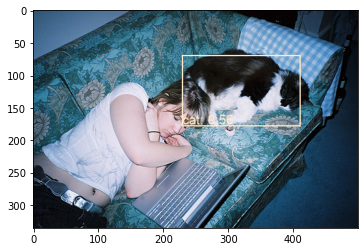

tensor([[14.],
        [14.]])
[tensor([[169.5364,  95.7555, 292.0949, 407.1505,   0.6162,   0.9999,  14.0000],
        [ 27.2386, 141.6434,  62.3533, 304.4336,   0.4510,   0.9999,  14.0000]])]
tensor([[169.5364,  95.7555, 292.0949, 407.1505,   0.6162,   0.9999,  14.0000],
        [ 27.2386, 141.6434,  62.3533, 304.4336,   0.4510,   0.9999,  14.0000]])


tensor([[14.]])
[tensor([[ 26.7535,  61.9513, 188.3992, 377.9203,   0.6202,   0.9948,  14.0000]])]
tensor([[ 26.7535,  61.9513, 188.3992, 377.9203,   0.6202,   0.9948,  14.0000]])


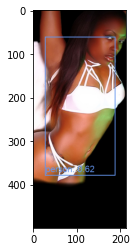

tensor([[6.]])
tensor([[14.],
        [14.]])
[tensor([[436.5436,  60.8552, 499.0000, 141.3460,   0.7726,   0.9999,   6.0000]]), tensor([[3.7978e+02, 7.1972e+01, 4.3475e+02, 2.4733e+02, 4.5917e-01, 1.0000e+00,
         1.4000e+01],
        [5.3118e+01, 7.9461e+01, 8.1645e+01, 2.0241e+02, 4.2091e-01, 9.9997e-01,
         1.4000e+01]])]
tensor([[4.3654e+02, 6.0855e+01, 4.9900e+02, 1.4135e+02, 7.7255e-01, 9.9992e-01,
         6.0000e+00],
        [3.7978e+02, 7.1972e+01, 4.3475e+02, 2.4733e+02, 4.5917e-01, 1.0000e+00,
         1.4000e+01],
        [5.3118e+01, 7.9461e+01, 8.1645e+01, 2.0241e+02, 4.2091e-01, 9.9997e-01,
         1.4000e+01]])


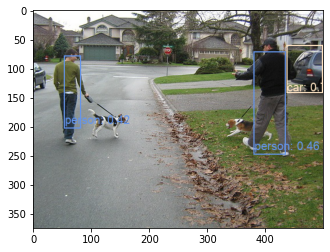

tensor([[14.]])
[tensor([[113.1347, 187.5483, 141.8759, 285.4604,   0.7400,   0.8017,  14.0000]])]
tensor([[113.1347, 187.5483, 141.8759, 285.4604,   0.7400,   0.8017,  14.0000]])


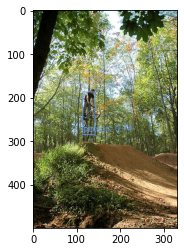

tensor([[14.]])
[tensor([[1.1159e+02, 1.0075e+02, 3.3049e+02, 2.9401e+02, 3.2398e-01, 9.9978e-01,
         1.4000e+01]])]
tensor([[1.1159e+02, 1.0075e+02, 3.3049e+02, 2.9401e+02, 3.2398e-01, 9.9978e-01,
         1.4000e+01]])


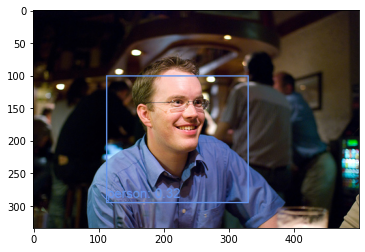

tensor([[7.]])
[tensor([[6.9268e+01, 9.3364e+01, 3.9068e+02, 3.0153e+02, 3.7765e-01, 9.9998e-01,
         7.0000e+00]])]
tensor([[6.9268e+01, 9.3364e+01, 3.9068e+02, 3.0153e+02, 3.7765e-01, 9.9998e-01,
         7.0000e+00]])


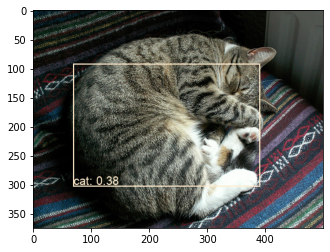

tensor([[1.]])
tensor([[14.]])
[tensor([[3.9547e+02, 2.9437e+02, 4.4497e+02, 3.4378e+02, 2.7147e-01, 9.8045e-01,
         1.0000e+00]]), tensor([[3.7266e+02, 1.5304e+02, 4.0038e+02, 3.4104e+02, 2.5473e-01, 1.0000e+00,
         1.4000e+01]])]
tensor([[3.9547e+02, 2.9437e+02, 4.4497e+02, 3.4378e+02, 2.7147e-01, 9.8045e-01,
         1.0000e+00],
        [3.7266e+02, 1.5304e+02, 4.0038e+02, 3.4104e+02, 2.5473e-01, 1.0000e+00,
         1.4000e+01]])


tensor([[14.]])
[tensor([[105.0455,  63.6551, 314.5249, 334.4573,   0.4670,   0.9984,  14.0000]])]
tensor([[105.0455,  63.6551, 314.5249, 334.4573,   0.4670,   0.9984,  14.0000]])


tensor([[18.]])
[tensor([[117.4420,  65.8017, 328.1938, 257.5916,   0.4666,   0.9989,  18.0000]])]
tensor([[117.4420,  65.8017, 328.1938, 257.5916,   0.4666,   0.9989,  18.0000]])


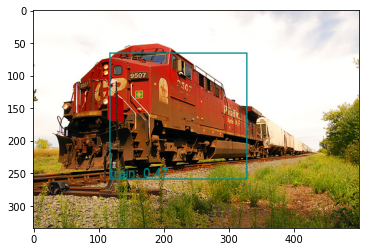

tensor([[1.]])
tensor([[14.]])
[tensor([[393.6195, 159.0039, 466.0280, 280.8956,   0.6546,   0.7937,   1.0000]]), tensor([[386.7373,  68.6517, 481.1901, 228.9294,   0.7609,   0.9999,  14.0000]])]
tensor([[393.6195, 159.0039, 466.0280, 280.8956,   0.6546,   0.7937,   1.0000],
        [386.7373,  68.6517, 481.1901, 228.9294,   0.7609,   0.9999,  14.0000]])


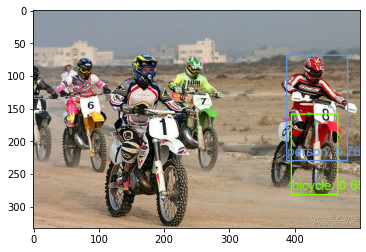

tensor([[14.]])
[tensor([[ 53.8754, 162.4890,  93.7166, 323.8263,   0.4530,   0.9999,  14.0000]])]
tensor([[ 53.8754, 162.4890,  93.7166, 323.8263,   0.4530,   0.9999,  14.0000]])


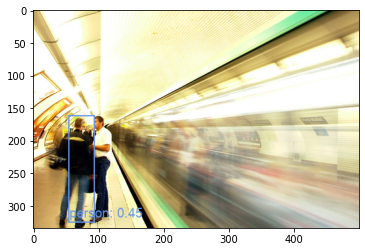

tensor([[14.]])
[tensor([[114.7559,  83.6061, 329.7797, 319.3531,   0.4665,   0.9998,  14.0000]])]
tensor([[114.7559,  83.6061, 329.7797, 319.3531,   0.4665,   0.9998,  14.0000]])


tensor([[13.]])
[tensor([[168.7608,  45.6967, 290.8453, 337.7703,   0.3529,   0.9992,  13.0000]])]
tensor([[168.7608,  45.6967, 290.8453, 337.7703,   0.3529,   0.9992,  13.0000]])


tensor([[1.]])
tensor([[14.]])
[tensor([[208.9534, 153.8952, 346.9533, 285.4273,   0.8440,   1.0000,   1.0000]]), tensor([[252.4034,  82.5338, 330.7381, 271.7324,   0.7125,   0.9989,  14.0000]])]
tensor([[208.9534, 153.8952, 346.9533, 285.4273,   0.8440,   1.0000,   1.0000],
        [252.4034,  82.5338, 330.7381, 271.7324,   0.7125,   0.9989,  14.0000]])


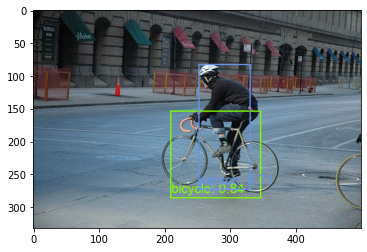

tensor([[6.]])
[tensor([[2.7611e+02, 1.8304e+02, 4.5150e+02, 2.7835e+02, 4.2772e-01, 9.4985e-01,
         6.0000e+00]])]
tensor([[2.7611e+02, 1.8304e+02, 4.5150e+02, 2.7835e+02, 4.2772e-01, 9.4985e-01,
         6.0000e+00]])


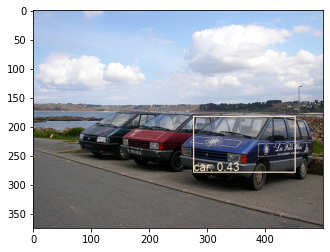

In [ ]:
import matplotlib.pyplot as plt


LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
BATCH_SIZE        = 32
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50

config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

data = pd.read_csv('/content/drive/My Drive/annotations.csv')
shuffled_data = data.sample(frac=1, random_state=1)
test_dataset = VOCPascal(shuffled_data.iloc[15500:15528, :], config, normalize, train=False)
test_dataloader = DataLoader(test_dataset, 32)
save_directory = '/content/drive/My Drive/detected_images'
pretrained_model = '/content/drive/My Drive/darknet19_448.weights'
model = Yolov2()
model.cuda()
model.load_state_dict(torch.load("/content/drive/My Drive/yolov2_150_.pth"))
model.eval()
with torch.no_grad():
    for batch, (im_data, im_infos, image_names) in enumerate(test_dataloader):
        image_names = list(image_names)
        im_data = im_data.cuda()
        out = model(im_data)
        xy_pred = torch.sigmoid(out[:, :, 0:2])
        conf_pred = torch.sigmoid(out[:, :, 4:5])
        hw_pred = torch.exp(out[:, :, 2:4])
        class_pred = F.softmax(out[:, :, 5:], dim=-1)
        delta_pred = torch.cat([xy_pred, hw_pred], dim=-1)
        for i in range(im_data.size(0)):
            output = [delta_pred[i], conf_pred[i], class_pred[i]]
            im_info = {'width': im_infos[i][0], 'height': im_infos[i][1]}
            detections = yolo_eval(output, im_info, conf_threshold=0.2,
                                       nms_threshold=0.4)
            img = Image.open(os.path.join(IMAGE_PATH, image_names[i]))
            if len(detections) == 0:
                continue
            print(detections)
            det_boxes = detections[:, :5].cpu().numpy()
            det_classes = detections[:, -1].long().cpu().numpy()
            im2show = draw_detection_boxes(img, det_boxes, det_classes, class_names=LABELS)
            # cv2.imwrite(os.path.join(save_directory, f'detection_{i}.png'), im2show)
            plt.figure()
            plt.imshow(im2show)
            plt.show()


In [ ]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        N = x.data.size(0)
        C = x.data.size(1)
        H = x.data.size(2)
        W = x.data.size(3)
        x = F.avg_pool2d(x, (H, W))
        x = x.view(N, C)
        return x


class Darknet19(nn.Module):
    def _make_layers(self, layer_cfg):
        layers = []
        kernel_size = 3
        for v in layer_cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += self.conv_bn_leaky(self.in_channels, v, kernel_size)
                kernel_size = 1 if kernel_size == 3 else 3
                self.in_channels = v
        return nn.Sequential(*layers)
    
    @staticmethod
    def conv_bn_leaky(in_channels, out_channels, kernel_size, return_module=False):
        padding = int((kernel_size - 1) / 2)
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                            stride=1, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1, inplace=True)]
        if return_module:
            return nn.Sequential(*layers)
        else:
            return layers

    cfg = {
        'layer0': [32],
        'layer1': ['M', 64],
        'layer2': ['M', 128, 64, 128],
        'layer3': ['M', 256, 128, 256],
        'layer4': ['M', 512, 256, 512, 256, 512],
        'layer5': ['M', 1024, 512, 1024, 512, 1024]
    }

    def __init__(self, num_classes=1000):
        super(Darknet19, self).__init__()
        self.in_channels = 3

        self.layer0 = self._make_layers(self.cfg['layer0'])
        self.layer1 = self._make_layers(self.cfg['layer1'])
        self.layer2 = self._make_layers(self.cfg['layer2'])
        self.layer3 = self._make_layers(self.cfg['layer3'])
        self.layer4 = self._make_layers(self.cfg['layer4'])
        self.layer5 = self._make_layers(self.cfg['layer5'])

        self.conv = nn.Conv2d(self.in_channels, num_classes, kernel_size=1, stride=1)
        self.avgpool = GlobalAvgPool2d()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.conv(x)
        x = self.avgpool(x)
        x = self.softmax(x)

        return x

class ReorgLayer(nn.Module):
    def __init__(self, stride=2):
        super(ReorgLayer, self).__init__()
        self.stride = stride

    def forward(self, x):
        B, C, H, W = x.data.size()
        ws = self.stride
        hs = self.stride
        x = x.view(B, C, int(H / hs), hs, int(W / ws), ws).transpose(3, 4).contiguous()
        x = x.view(B, C, int(H / hs * W / ws), hs * ws).transpose(2, 3).contiguous()
        x = x.view(B, C, hs * ws, int(H / hs), int(W / ws)).transpose(1, 2).contiguous()
        x = x.view(B, hs * ws * C, int(H / hs), int(W / ws))
        return x


class Yolov2(nn.Module):

    num_classes = 20
    num_anchors = 5



    def box_ious(self, box1, box2):
        N = box1.size(0)
        K = box2.size(0)

        xi1 = torch.max(box1[:, 0].view(N, 1), box2[:, 0].view(1, K))
        yi1 = torch.max(box1[:, 1].view(N, 1), box2[:, 1].view(1, K))
        xi2 = torch.min(box1[:, 2].view(N, 1), box2[:, 2].view(1, K))
        yi2 = torch.min(box1[:, 3].view(N, 1), box2[:, 3].view(1, K))

        iw = torch.max(xi2 - xi1, torch.tensor([0.], dtype=torch.float))
        ih = torch.max(yi2 - yi1, torch.tensor([0.], dtype=torch.float))

        inter = iw * ih

        box1_area = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
        box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

        box1_area = box1_area.view(N, 1)
        box2_area = box2_area.view(1, K)

        union_area = box1_area + box2_area - inter

        ious = inter / union_area

        return ious


    def xxyy2xywh(self, box):
        c_x = (box[:, 2] + box[:, 0]) / 2
        c_y = (box[:, 3] + box[:, 1]) / 2
        w = box[:, 2] - box[:, 0]
        h = box[:, 3] - box[:, 1]

        c_x = c_x.view(-1, 1)
        c_y = c_y.view(-1, 1)
        w = w.view(-1, 1)
        h = h.view(-1, 1)

        xywh_box = torch.cat([c_x, c_y, w, h], dim=1)
        return xywh_box


    def xywh2xxyy(self, box):
        x1 = box[:, 0] - (box[:, 2]) / 2
        y1 = box[:, 1] - (box[:, 3]) / 2
        x2 = box[:, 0] + (box[:, 2]) / 2
        y2 = box[:, 1] + (box[:, 3]) / 2

        x1 = x1.view(-1, 1)
        y1 = y1.view(-1, 1)
        x2 = x2.view(-1, 1)
        y2 = y2.view(-1, 1)

        xxyy_box = torch.cat([x1, y1, x2, y2], dim=1)
        return xxyy_box


    def box_transform(self, box1, box2):
        t_x = box2[:, 0] - box1[:, 0]
        t_y = box2[:, 1] - box1[:, 1]
        t_w = box2[:, 2] / box1[:, 2]
        t_h = box2[:, 3] / box1[:, 3]

        t_x = t_x.view(-1, 1)
        t_y = t_y.view(-1, 1)
        t_w = t_w.view(-1, 1)
        t_h = t_h.view(-1, 1)

        # σ(t_x), σ(t_y), exp(t_w), exp(t_h)
        deltas = torch.cat([t_x, t_y, t_w, t_h], dim=1)
        return deltas


   
    def box_transform_inv(self, box, deltas):
        c_x = box[:, 0] + deltas[:, 0]
        c_y = box[:, 1] + deltas[:, 1]
        w = box[:, 2] * deltas[:, 2]
        h = box[:, 3] * deltas[:, 3]

        c_x = c_x.view(-1, 1)
        c_y = c_y.view(-1, 1)
        w = w.view(-1, 1)
        h = h.view(-1, 1)

        pred_box = torch.cat([c_x, c_y, w, h], dim=-1)
        return pred_box


    def generate_all_anchors(self, anchors, H, W):
        A = anchors.size(0)

        K = H * W

        shift_x, shift_y = torch.meshgrid([torch.arange(0, W), torch.arange(0, H)])

        shift_x = shift_x.t().contiguous()
        shift_y = shift_y.t().contiguous()

        c_x = shift_x.float()
        c_y = shift_y.float()

        centers = torch.cat([c_x.view(-1, 1), c_y.view(-1, 1)], dim=-1) 
        all_anchors = torch.cat([centers.view(K, 1, 2).expand(K, A, 2),
                                anchors.view(1, A, 2).expand(K, A, 2)], dim=-1)

        all_anchors = all_anchors.view(-1, 4)

        return all_anchors


    def yolo_filter_boxes(self, boxes_pred, conf_pred, classes_pred, confidence_threshold=0.6):
        cls_max_conf, cls_max_id = torch.max(classes_pred, dim=-1, keepdim=True)
        cls_conf = conf_pred * cls_max_conf

        pos_inds = (cls_conf > confidence_threshold).view(-1)

        filtered_boxes = boxes_pred[pos_inds, :]

        filtered_conf = conf_pred[pos_inds, :]

        filtered_cls_max_conf = cls_max_conf[pos_inds, :]

        filtered_cls_max_id = cls_max_id[pos_inds, :]

        return filtered_boxes, filtered_conf, filtered_cls_max_conf, filtered_cls_max_id.float()


    def yolo_nms(self, boxes, scores, threshold):
        score_sort_index = torch.sort(scores, dim=0, descending=True)[1]

        keep = []

        while score_sort_index.numel() > 0:

            i = score_sort_index[0]
            keep.append(i)

            if score_sort_index.numel() == 1:
                break

            cur_box = boxes[score_sort_index[0], :].view(-1, 4)
            res_box = boxes[score_sort_index[1:], :].view(-1, 4)

            ious = self.box_ious(cur_box, res_box).view(-1)

            inds = torch.nonzero(ious < threshold).squeeze()

            score_sort_index = score_sort_index[inds + 1].view(-1)

        return torch.LongTensor(keep)


  
    def generate_prediction_boxes(self, deltas_pred):
        H = int(320 / 32)
        W = int(320 / 32)
        anchors = torch.FloatTensor([[1.3221, 1.73145], [3.19275, 4.00944], [5.05587, 8.09892], [9.47112, 4.84053], [11.2364, 10.0071]])
        all_anchors_xywh = self.generate_all_anchors(anchors, H, W)

        all_anchors_xywh = deltas_pred.new(*all_anchors_xywh.size()).copy_(all_anchors_xywh)

        boxes_pred = self.box_transform_inv(all_anchors_xywh, deltas_pred)

        return boxes_pred

   
    def scale_boxes(self, boxes, im_info):
        h = im_info['height']
        w = im_info['width']

        input_h, input_w = 320, 320
        # scale_h, scale_w = input_h / h, input_w / w

        boxes *= 32

        # boxes[:, 0::2] /= scale_w
        # boxes[:, 1::2] /= scale_h

        boxes = self.xywh2xxyy(boxes)

        boxes[:, 0::2].clamp_(0, w-1)
        boxes[:, 1::2].clamp_(0, h-1)

        return boxes


    def yolo_eval(self, yolo_output, im_info, conf_threshold=0.6, nms_threshold=0.4):
        deltas = yolo_output[0].cpu()
        conf = yolo_output[1].cpu()
        classes = yolo_output[2].cpu()

        num_classes = 20
        
        boxes = self.generate_prediction_boxes(deltas)


        boxes, conf, cls_max_conf, cls_max_id = self.yolo_filter_boxes(boxes, conf, classes, conf_threshold)


        if boxes.size(0) == 0:
            return []

        boxes = self.scale_boxes(boxes, im_info)

        detections = []
        clss = []
        cls_max_id = cls_max_id.view(-1)

        for cls in range(num_classes):
            cls_mask = cls_max_id == cls
            inds = torch.nonzero(cls_mask).squeeze()

            if inds.numel() == 0:
                continue

            boxes_pred_class = boxes[inds, :].view(-1, 4)
            conf_pred_class = conf[inds, :].view(-1, 1)
            cls_max_conf_class = cls_max_conf[inds].view(-1, 1)
            classes_class = cls_max_id[inds].view(-1, 1)

            nms_keep = self.yolo_nms(boxes_pred_class, conf_pred_class.view(-1), nms_threshold)

            boxes_pred_class_keep = boxes_pred_class[nms_keep, :]
            conf_pred_class_keep = conf_pred_class[nms_keep, :]
            cls_max_conf_class_keep = cls_max_conf_class.view(-1, 1)[nms_keep, :]
            classes_class_keep = classes_class.view(-1, 1)[nms_keep, :]
            
            seq = [boxes_pred_class_keep, conf_pred_class_keep, cls_max_conf_class_keep, classes_class_keep.float()]

            detections_cls = torch.cat(seq, dim=-1)
            detections.append(detections_cls)
        return torch.cat(detections, dim=0)


    @staticmethod
    def conv_bn_leaky(in_channels, out_channels, kernel_size, return_module=False):
        padding = int((kernel_size - 1) / 2)
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                            stride=1, padding=padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1, inplace=True)]
        if return_module:
            return nn.Sequential(*layers)
        else:
            return layers

    
    def __init__(self, classes=None, weights_file=False):
        super(Yolov2, self).__init__()
        if classes:
            self.num_classes = len(classes)

        darknet19 = Darknet19()

        self.conv1 = nn.Sequential(darknet19.layer0, darknet19.layer1,
                                   darknet19.layer2, darknet19.layer3, darknet19.layer4)

        self.conv2 = darknet19.layer5

        self.conv3 = nn.Sequential(self.conv_bn_leaky(1024, 1024, kernel_size=3, return_module=True),
                                   self.conv_bn_leaky(1024, 1024, kernel_size=3, return_module=True))

        self.downsampler = self.conv_bn_leaky(512, 64, kernel_size=1, return_module=True)

        self.conv4 = nn.Sequential(self.conv_bn_leaky(1280, 1024, kernel_size=3, return_module=True),
                                   nn.Conv2d(1024, (5 + self.num_classes) * self.num_anchors, kernel_size=1))

        self.reorg = ReorgLayer()


    def forward(self, x):
        x = self.conv1(x)
        shortcut = self.reorg(self.downsampler(x))
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.cat([shortcut, x], dim=1)
        out = self.conv4(x)


        bsize, _, h, w = out.size()
        out  = out.permute(0, 2, 3, 1).contiguous().view(bsize, h * w * self.num_anchors, 5 + self.num_classes)

        xy_pred = torch.sigmoid(out[:, :, 0:2])
        conf_pred = torch.sigmoid(out[:, :, 4:5])
        hw_pred = torch.exp(out[:, :, 2:4])
        class_pred = F.softmax(out[:, :, 5:], dim=-1)
        delta_pred = torch.cat([xy_pred, hw_pred], dim=-1)

        for i in range(bsize):
            output = [delta_pred[i], conf_pred[i], class_pred[i]]
            im_info = {'width': w, 'height': h}
            detections = self.yolo_eval(output, im_info, conf_threshold=0.2,
                                          nms_threshold=0.4)
        
        det_classes = detections[:,-1]
        return det_classes


In [ ]:
torch.cuda.empty_cache()
train_image_folder = "/content/drive/My Drive/test1/test2/test3/JPEGImages/"
train_annot_folder = "/content/drive/My Drive/temp1/temp2/Annotations/"
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
device = torch.device("cuda")
BATCH_SIZE        = 32
IMAGE_H, IMAGE_W  = 320,320
GRID_H,  GRID_W   = 10,10
TRUE_BOX_BUFFER   = 50

config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

data = pd.read_csv('/content/drive/My Drive/annotations.csv', dtype=types)
shuffled_data = data.sample(frac=1, random_state=1)
train_dataset = VOCPascal(shuffled_data.iloc[:15040, :], config, normalize)
print('Dataset ready!')
dataloaders = dict()

dataloaders['train'] = DataLoader(train_dataset, BATCH_SIZE)
print('DataLoader ready!')
pretrained_model = '/content/drive/My Drive/darknet19_448.weights'
model = Yolov2(weights_file=pretrained_model)
print('Weights loaded!')
model.cuda()
lr = 0.0001
model.load_state_dict(torch.load('/content/drive/My Drive/yolov2_125_.pth'))
print('Model loaded')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)
model.train()
epochs = 140
print('Train begin!')
for epoch in range(epochs):
    # if (epoch + 1) % 50 == 0 or (epoch + 1) % 80 == 0:
    #     lr = decay_lrs[epoch+1]
    #     adjust_learning_rate(optimizer, lr)
    #     print('adjust learning rate to {}'.format(lr))
    # if (epoch + 1) in decay_lrs:
    #     lr = decay_lrs[epoch+1]
    #     adjust_learning_rate(optimizer, lr)
    #     print(f'adjust learning rate to {lr}') 
    running_loss = torch.tensor([0.0])
    running_boxes_loss = torch.tensor([0.0])
    running_iou_loss = torch.tensor([0.0])
    running_class_loss = torch.tensor([0.0])
    print(f'Epoch {epoch + 126}/{epochs}')
    tic = time.time()
    for i, (image_batch, boxes_batch, gt_classes_batch, num_obj_batch) in enumerate(dataloaders['train']):
        image_batch = (image_batch).to(device)
        boxes_batch = (boxes_batch).to(device)
        gt_classes_batch = (gt_classes_batch).to(device)
        num_obj_batch = (num_obj_batch).to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            y_pred = model(image_batch)
            boxes_loss, iou_loss, class_loss = loss_func(y_pred, boxes_batch, gt_classes_batch, num_obj_batch)
            loss = boxes_loss.mean() + iou_loss.mean() + class_loss.mean()
            running_loss += loss
            running_boxes_loss += boxes_loss.mean()
            running_iou_loss += iou_loss.mean()
            running_class_loss += class_loss.mean()

            
            loss.backward()
            optimizer.step()
            
            print(f'Batch: {i} \t Epoch: {epoch + 126} \t Loss:{loss.item():.4f}')
    toc = time.time()
    tb.add_scalar('Localization Loss', running_boxes_loss.mean().item()/470, epoch + 125)
    tb.add_scalar('IOU Loss', running_iou_loss.mean().item()/470, epoch + 125)
    tb.add_scalar('Classification Loss', running_class_loss.mean().item()/470, epoch + 125)
    tb.add_scalar('Total Loss', running_loss.mean().item()/470, epoch + 125)
    print(f"Epoch {epoch + 126} time = {toc-tic}")
    print(f"Epoch {epoch + 126} loss = {running_loss.mean().item()/470:.4f}")
    if (epoch + 126) % 5 == 0:
        torch.save(model.state_dict(), f'/content/drive/My Drive/yolov2_{epoch + 126}_.pth')
    # print(f'Epoch: {epoch + 1} \t Loss: {running_loss/len(dataloaders['train'].dataset)} \t Time of Epoch: {(toc-tic):.2f}')
